In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import ndac
%matplotlib inline
#this is the grid search with progress bar 
# pip install git+https://github.com/pactools/pactools.git#egg=pactools
#from pactools.grid_search import GridSearchCVProgressBar 

C:\Users\Jay\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


45206 samples input.
11303 samples above high cut, 11302 samples below low cut, 22601 samples removed.


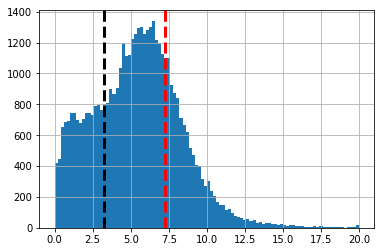

In [3]:
#read in the data and classify
data = pd.read_csv('dataframes/DF_prest.csv', index_col=0)
data, hist = ndac.quantile_classify(data['conc_cf'], data['aa_seq'])

In [8]:
# setup 'docs' for use with Tokenizer
def aa_seq_doc(aa_sequence):
    """This function takes in an amino acid sequence (aa sequence) and adds spaces between each amino acid."""
    
    return ' '.join([aa_sequence[i:i+1] 
                     for i in range(0, len(aa_sequence))])
data['aa_seq_doc'] = data['aa_seq'].apply(aa_seq_doc)
data = data[pd.notnull(data['aa_seq_doc'])]

# check shape
print('data shape: ', data.shape)

data shape:  (22605, 4)


In [9]:
# define sequence documents
docs = list(data['aa_seq_doc'])
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

# integer encode documents
X = t.texts_to_sequences(docs)
y = data['class'].values

# fix random seed for reproducibility
np.random.seed(27315)

# load the dataset but only keep the top n words, zero the rest
top_words = len(t.word_index) + 1

# truncate and pad input sequences
seq_lengths = [len(seq) for seq in X]
max_seq_length = max(seq_lengths)
X = sequence.pad_sequences(X, maxlen=max_seq_length)

In [14]:
# tune hyperparameters for simple model

# model based on "A C-LSTM Neural Network for Text Classification"

def create_model(embedding_length=16, num_filters=128, pool_size=2,
                 lstm_nodes=100, drop=0.5, recurrent_drop=0.5, filter_length=3):
    # create the model
    model = Sequential()
    model.add(Embedding(top_words, embedding_length, 
                        input_length=max_seq_length))
    model.add(Conv1D(filters=num_filters, kernel_size=filter_length, 
                     padding='same', activation='selu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_nodes, dropout=drop, 
              recurrent_dropout=recurrent_drop))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

    return model


model = KerasClassifier(build_fn=create_model, batch_size=64,
                        epochs=30, verbose=10)
# define the grid search parameters
# model hyperparameters
embedding_length = [4, 6, 8]
num_filters = [50, 100, 200]
filter_length = [3, 5, 8]
pool_size = [3, 4]
lstm_nodes = [100, 200]

param_grid = dict(num_filters=num_filters, pool_size=pool_size,
                  lstm_nodes=lstm_nodes, filter_length=filter_length)

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=3, verbose=10)#, n_jobs=28)
# grid = GridSearchCVProgressBar(estimator=model, param_grid=param_grid,
#                     cv=3, verbose=10)

grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

grid_df = pd.DataFrame(grid_result.cv_results_['params'])
grid_df['mean'] = grid_result.cv_results_['mean_test_score']
grid_df['stddev'] = grid_result.cv_results_['std_test_score']

# print results to csv file
grid_df.to_csv('2018-06-14_aa_gird_search_results.csv')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3 ......
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
[CV]  filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3, score=0.5702720635524235, total=   9.6s
[CV] filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3, score=0.4910418049499699, total=   9.0s
[CV] filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3 ......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s


[CV]  filter_length=2, lstm_nodes=10, num_filters=5, pool_size=3, score=0.4828135368993287, total=   9.6s
[CV] filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3 ......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.1s remaining:    0.0s


[CV]  filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3, score=0.5844724616627861, total=   9.6s
[CV] filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3 ......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.2s remaining:    0.0s


[CV]  filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3, score=0.5039150629719125, total=  10.3s
[CV] filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3 ......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.9s remaining:    0.0s


[CV]  filter_length=3, lstm_nodes=10, num_filters=5, pool_size=3, score=0.42003981414898073, total=  10.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min finished


Best: 0.514709 using {'filter_length': 2, 'lstm_nodes': 10, 'num_filters': 5, 'pool_size': 3}
